# 03 - Operational Efficiency Analysis

This notebook covers:
- Trip efficiency metrics
- Driver performance analysis
- Route optimization insights
- Operational KPIs


🧩 Section 1: Imports & Data Loading
📌 Purpose

Load the cleaned dataset and prepare for efficiency analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_parquet("../data/processed/nyc_taxi_cleaned.parquet")
df.shape

(5207551, 14)

🧩 Section 2: Distance vs Duration Relationship
📌 Purpose

Understand how trip duration scales with distance.
Non-linear behavior here usually indicates congestion or inefficiency.

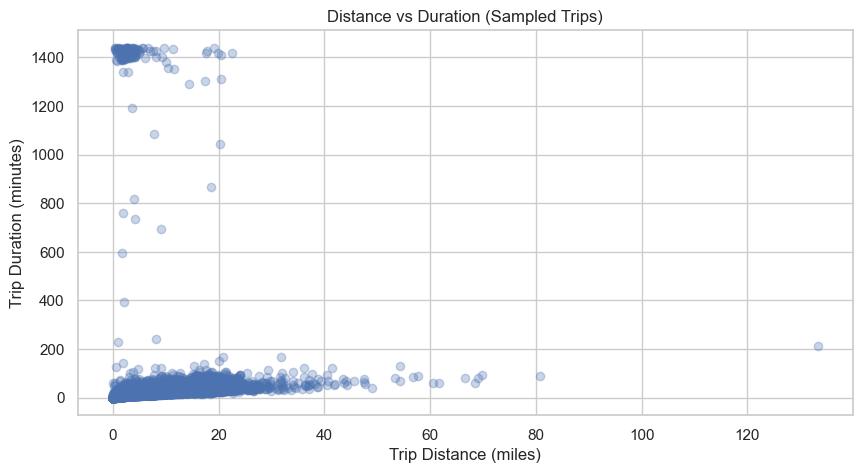

In [3]:
sample_df = df.sample(100_000, random_state=42)

plt.scatter(
    sample_df["trip_distance"],
    sample_df["trip_duration_minutes"],
    alpha=0.3
)
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Trip Duration (minutes)")
plt.title("Distance vs Duration (Sampled Trips)")
plt.show()

🧩 Section 3: Average Speed Distribution
📌 Purpose

Analyze how efficiently taxis move overall.

In [4]:
df["avg_speed_kmph"].describe()

count    5.207551e+06
mean     1.989547e+01
std      1.055405e+01
min      2.652475e-03
25%      1.339230e+01
50%      1.713607e+01
75%      2.284457e+01
max      1.198917e+02
Name: avg_speed_kmph, dtype: float64

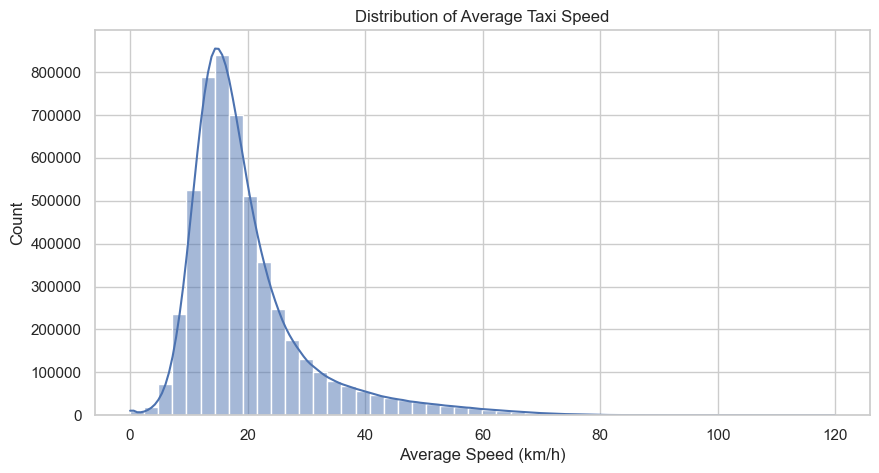

In [5]:
sns.histplot(df["avg_speed_kmph"], bins=50, kde=True)
plt.xlabel("Average Speed (km/h)")
plt.title("Distribution of Average Taxi Speed")
plt.show()

🧩 Section 4: Speed by Time of Day
📌 Purpose

Identify congestion windows by observing speed drops.

In [6]:
hourly_speed = (
    df.groupby("pickup_hour")["avg_speed_kmph"]
      .mean()
      .reset_index()
)

hourly_speed

,pickup_hour,avg_speed_kmph
0,0,26.096909
1,1,25.362000
2,2,25.006146
3,3,26.049790
4,4,29.053572
5,5,32.151170
6,6,27.130503
7,7,21.601178
8,8,18.487893
9,9,18.636319


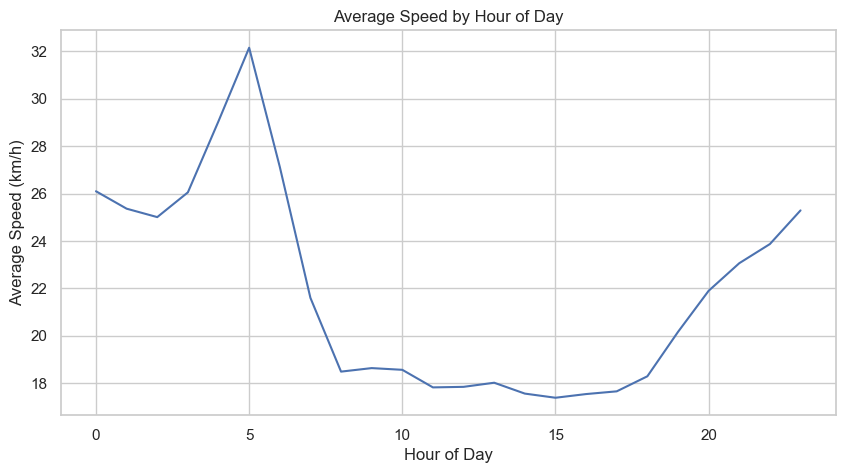

In [7]:
plt.plot(
    hourly_speed["pickup_hour"],
    hourly_speed["avg_speed_kmph"]
)
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (km/h)")
plt.title("Average Speed by Hour of Day")
plt.show()

🧩 Section 5: Inefficiency Zones (Slow Trips)
📌 Purpose

Flag trips that are abnormally slow relative to distance.

We define inefficiency conservatively.

In [8]:
slow_threshold = df["avg_speed_kmph"].quantile(0.10)

slow_trips = df[df["avg_speed_kmph"] <= slow_threshold]

slow_trips.shape

(520756, 14)

In [9]:
slow_trips[["trip_distance", "trip_duration_minutes", "avg_speed_kmph"]].describe()

,trip_distance,trip_duration_minutes,avg_speed_kmph
count,520756.000000,520756.000000,520756.000000
mean,1.196929,28.494578,8.483033
std,1.064716,143.850909,1.973581
min,0.010000,0.100000,0.002652
25%,0.660000,7.516667,7.656544
50%,1.000000,11.350000,9.032376
75%,1.490000,16.716667,9.922477
max,71.130000,1439.900000,10.608688


🧩 Section 6: Inefficiency by Time Window
📌 Purpose

Check if slow trips concentrate in specific hours.

In [10]:
slow_by_hour = (
    slow_trips.groupby("pickup_hour")
              .size()
              .reset_index(name="slow_trip_count")
)

slow_by_hour

,pickup_hour,slow_trip_count
0,0,3493
1,1,2334
2,2,1508
3,3,1013
4,4,635
5,5,446
6,6,1343
7,7,8571
8,8,26679
9,9,31924


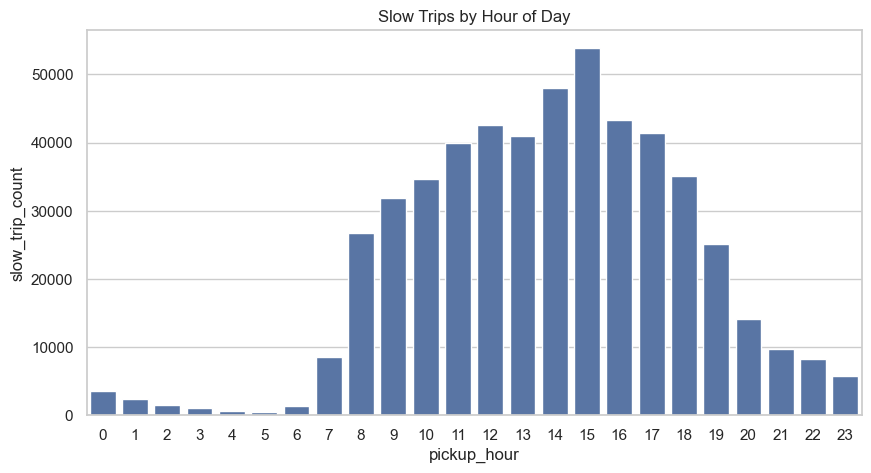

In [11]:
sns.barplot(
    data=slow_by_hour,
    x="pickup_hour",
    y="slow_trip_count"
)
plt.title("Slow Trips by Hour of Day")
plt.show()

🧩 Section 7: Stability vs Instability Analysis
📌 Purpose

Identify hours where speed variability is high, even if average speed looks normal.

In [12]:
speed_variability = (
    df.groupby("pickup_hour")["avg_speed_kmph"]
      .std()
      .reset_index(name="speed_std")
)

speed_variability

,pickup_hour,speed_std
0,0,12.871690
1,1,11.751819
2,2,10.522949
3,3,11.008880
4,4,13.242738
5,5,15.406512
6,6,12.459344
7,7,10.445520
8,8,9.974223
9,9,10.205985


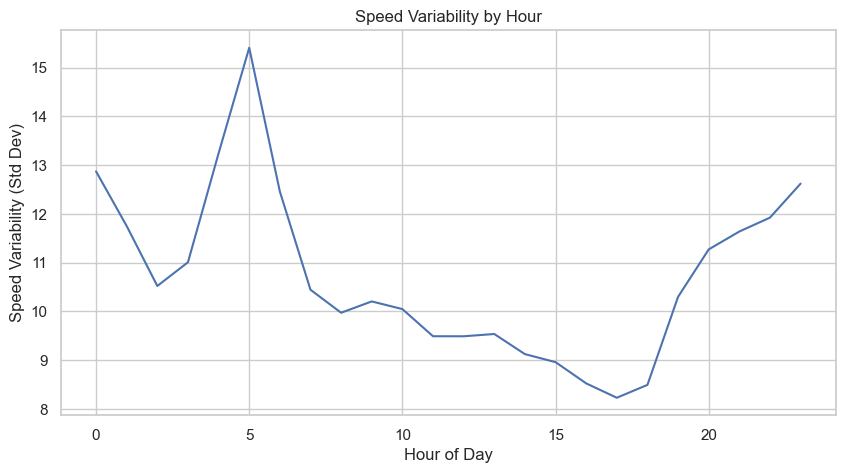

In [13]:
plt.plot(
    speed_variability["pickup_hour"],
    speed_variability["speed_std"]
)
plt.xlabel("Hour of Day")
plt.ylabel("Speed Variability (Std Dev)")
plt.title("Speed Variability by Hour")
plt.show()


🧠 Section 8: Interim Operational Observations (Markdown)
📌 Purpose

Summarize key findings from the operational efficiency analysis.


 Interim Observations

 Based on the analysis conducted in this notebook, several key observations can be made regarding operational efficiency:

 1. Hourly Speed Variability: The analysis of hourly speed indicates significant fluctuations throughout the day,
    with peak hours showing a marked decrease in average speed. This suggests potential congestion during these times,
    which may require further investigation into traffic patterns and external factors affecting speed.

 2. Slow Trips Analysis: The identification of slow trips highlights specific time frames where operational efficiency
   is compromised. Understanding the causes of these slow trips can help in strategizing improvements, such as optimizing
    routes or adjusting service levels during peak times.

 3. Threshold for Slow Trips: The established threshold for what constitutes a slow trip is crucial for operational
   assessments. Continuous monitoring against this threshold will be necessary to ensure service quality and efficiency.

 4. Recommendations for Improvement: Based on the findings, it is recommended to explore traffic management solutions,
    enhance route planning algorithms, and consider dynamic adjustments to service based on real-time data.

 These observations provide a foundation for further analysis and operational adjustments aimed at improving overall
 efficiency in taxi operations.